Status: in progress (remarks will be available soon)

Remark: All the analysis is going to be aggregating all the data by hour, so doing it in that way, we can analyse all the years together and compare them

In [2]:
# packages 
import pandas as pd
import numpy as np
from pymongo import MongoClient
import missingno as msno 

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_theme(style="ticks")




In [3]:
## connecting
db_name = "meteo_lasilla"
client = MongoClient("mongodb://localhost:27017/")
db = client[db_name] # meteo_paranal_test
collection = db[db_name]

## Counting Samples

In [11]:
print('Expected samples per year: ', 60*24*365) # asuming that we have un sample per minute

Expected samples per year:  525600


In [4]:

## samples per year
pipeline = [
    {   # it extracts the year from Date time
        "$project": { "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},}
    },
    { "$group": {# grouping by year and sum per sample 
            "_id": "$year",
            "count": {"$sum": 1}}
    },
    {"$sort": {"_id": 1}  # sort by year in ascending order
    }
]
result = list(collection.aggregate(pipeline))
for result_it in result:
    print(f"Year: {result_it['_id']}, Count: {result_it['count']}")

Year: 1991, Count: 2
Year: 1993, Count: 1935
Year: 1994, Count: 159651
Year: 1995, Count: 152038
Year: 1996, Count: 164892
Year: 1997, Count: 230500
Year: 1998, Count: 369322
Year: 1999, Count: 449286
Year: 2000, Count: 426784
Year: 2001, Count: 255628
Year: 2002, Count: 256237
Year: 2003, Count: 258165
Year: 2004, Count: 255047
Year: 2005, Count: 254790
Year: 2006, Count: 255003
Year: 2007, Count: 258633
Year: 2008, Count: 158175
Year: 2010, Count: 256111
Year: 2011, Count: 496978
Year: 2012, Count: 499619
Year: 2013, Count: 502408
Year: 2014, Count: 320822
Year: 2015, Count: 412360
Year: 2016, Count: 447534
Year: 2017, Count: 502776
Year: 2018, Count: 482943
Year: 2019, Count: 505830
Year: 2020, Count: 408280
Year: 2021, Count: 476174
Year: 2022, Count: 449252
Year: 2023, Count: 387030
Year: 2024, Count: 28100


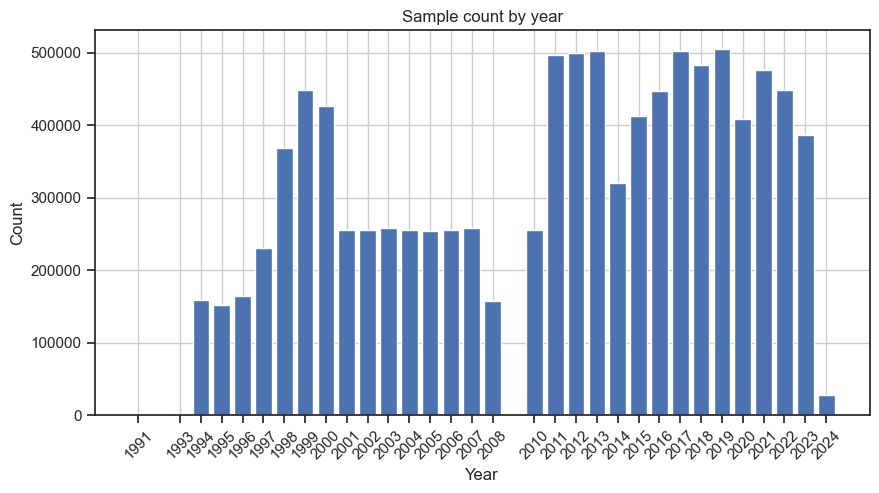

In [10]:
years = [result_it['_id'] for result_it in result]
counts = [result_it['count'] for result_it in result]

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(years, counts)
plt.xticks(years,rotation=45)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Sample count by year')
plt.grid(True)
plt.show()

In [145]:
## utils (skip this cell)
numeric_col = [
'Air Pressure at 2m [hPa]', 
'Air Pressure Normalised [hPa]', 
'Ambient Temperature at 30m [C]', 
'Ambient Temperature at 2m [C]', 
'Ambient Temperature at ground [C]', 
'Dew Temperature at 2m [C]', 
'Relative Humidity at 2m [%]', 
'Wind Direction at 30m [deg]', 
'Wind Direction at 10m [deg]', 
'Wind Speed at 30m [m/s]', 
'Wind Speed at 10m [m/s]'
 ]

def dict_to_datetime(x):
   return f"{x['year']}-{x['month']}-{x['day']} {x['hour']}:00:00"


def get_datetime_index(df):
    df['_id'] = pd.to_datetime(df['_id'].apply(dict_to_datetime))
    df = df.set_index(['_id'])
    df = df.sort_index(ascending=True)
    return df

def get_df(aggregated_expression):

    pipeline = [
        {"$group": {
                "_id": {
                    "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},
                    "month": {"$month": {"$dateFromString": {"dateString": "$Date time"}}},
                    "day": {"$dayOfMonth": {"$dateFromString": {"dateString": "$Date time"}}},
                    "hour": {"$hour": {"$dateFromString": {"dateString": "$Date time"}}},
                }, 
                **aggregated_expression}},
        {"$sort": {"_id.year": 1, "_id.month": 1, "_id.day": 1, "_id.hour": 1} }
    ]

    result = list(collection.aggregate(pipeline))

    return pd.DataFrame(result)



## plot functions
def plot_and_save_hexbin(variable1,variable2):
    plt.clf()
    sns.jointplot(x=df[variable1], y=df[variable2], kind="hex", color="#4CB391")
    plt.xlabel(f'{variable1}')
    plt.ylabel(f'{variable2}')
    # plt.title(f'Scatterplot {variable1} and {variable2}')
    plt.savefig(f"../plots/scatterplot/Scatterplot_{variable1.replace('/','')}_&&&_{variable2.replace('/','')}.png",dpi=100)

def plot_and_save_scatter(variable1,variable2):
    plt.clf()
    sns.jointplot(x=variable1,y=variable2,data=df)
    plt.xlabel(f'{variable1}')
    plt.ylabel(f'{variable2}')
    # plt.title(f'Scatterplot {variable1} and {variable2}')
    plt.savefig(f"../plots/scatterplot/Scatterplot_{variable1.replace('/','')}_&&&_{variable2.replace('/','')}.png",dpi = 100)

def plot_historic_histogram(variable):
    plt.clf()
    df[variable].plot(kind='hist',bins=100, title=f'Histogram for {variable}')
    plt.savefig(f"../plots/historic_histograms/histogram_{variable.replace('/','')}.png",dpi = 100)

def plot_density_by_year(variable):
    grouped_data = df.groupby(df.index.year)
    fig, axes = plt.subplots(nrows=len(grouped_data), figsize=(10, 5 * len(grouped_data)))
    for i, (year, group) in enumerate(grouped_data):
        sns.kdeplot(data=group[variable], ax=axes[i], fill=True, label=f'Year {year}')
        axes[i].set_title(f'Year {year}')
        # group[variable].plot(kind='hist', ax=axes[i], bins=10, title=f'Histogram for Year {year}')
        axes[i].set_xlim(df[variable].min(), df[variable].max())

    axes[-1].set_xlabel(variable)
    axes[-1].set_ylabel('Density')
    plt.tight_layout()
    plt.savefig(f"../plots/histograms_per_year/density_by_year_for_{variable.replace('/','')}.png",dpi = 100)

def plot_timeseries_err(variable):
    plt.clf()

    fig, ax = plt.subplots(figsize=(20, 7))
    plt.plot(df.index, df[variable], label = None)
    plt.fill_between (df_std.index, df[variable]-df_std[variable], df[variable]+df_std[variable], color='gray', alpha=0.3) # plot de la desviación
    plt.title(f'Historical time series for {variable}')
    plt.xlabel('Date')
    plt.ylabel(variable)
    # plt.gcf().set_size_inches(20, 7)
    for year in df.index.year.unique():
        plt.axvline(pd.to_datetime(f'{year}-01-01'), linestyle='--', color='black', alpha=0.5)
        plt.xticks(rotation=45, ha='right')

    plt.savefig(f"../plots/timeseries/timeseries_error_{variable.replace('/','')}.png", dpi=100)

def plot_timeseries_subplots(variable):
    plt.clf()

    df['hourofyear'] = 24 * (df.index.dayofyear - 1) + df.index.hour
    
    unique_years = df.index.year.unique()
    num_years = len(unique_years)
    fig, axes = plt.subplots(nrows=num_years, ncols=1, figsize=(20, 7*num_years), sharex=True)

    for i, year in enumerate(unique_years):
        ax = axes[i] 
        year_data = df[df.index.year == year]
        # year_data_std = df_std[df_std.index==year]

        ax.plot(year_data.hourofyear, year_data[variable], label=None,linestyle='None', marker='o', markersize=2)
        ax.set_title(f'Historical time series for {variable} - Year {year}')
        ax.set_ylabel(variable)
        ax.tick_params(axis='x', rotation=45,)

    plt.xlabel('Date')
    plt.tight_layout()
    plt.savefig(f"../plots/timeseries_subplots/timeseries_subplots_{variable.replace('/','')}.png", dpi=100)


# correlation function
def get_principal_correlations(df_corr,n_display):

    upper_triangle_correlation = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
    top_positive_correlations = upper_triangle_correlation.unstack().sort_values(ascending=False)[:n_display]
    top_negative_correlations = upper_triangle_correlation.unstack().sort_values(ascending=True)[:n_display]

    rename_columns={'level_0':'feature1','level_1':'feature2',0:'Correlation'}

    less_correlated = upper_triangle_correlation.unstack().reset_index()
    less_correlated.rename(columns=rename_columns,inplace=True)
    less_correlated.Correlation=less_correlated.Correlation.apply(lambda x : abs(x))
    less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]

    top_positive_correlations=top_positive_correlations.reset_index()
    top_positive_correlations.rename(columns=rename_columns,inplace=True)

    top_negative_correlations=top_negative_correlations.reset_index()
    top_negative_correlations.rename(columns=rename_columns,inplace=True)


    return top_negative_correlations,top_positive_correlations,less_correlated


Remark: that pipeline calculate the average per period only in the numeric values. Nan values are not be considered:
https://www.mongodb.com/docs/manual/reference/operator/aggregation/avg/

In [31]:
## uploading data

# defining what we want
mean_agg = {f: {"$avg": f"${f}"} for f in numeric_col}
std_agg = {f: {"$stdDevSamp": f"${f}"} for f in numeric_col}
# min_agg = {f: {"$min": f"${f}"} for f in numeric_col}
# max_agg = {f: {"$max": f"${f}"} for f in numeric_col}

# getting df
df_mean = get_df(mean_agg)
df_std = get_df(std_agg)
# df_min = get_df(min_agg)
# df_max = get_df(max_agg)

# getting datetime index sorted
df_mean = get_datetime_index(df_mean)
df_std = get_datetime_index(df_std)
# df_min = get_datetime_index(df_min)
# df_max = get_datetime_index(df_max)


In [141]:
df=df_mean.copy() # just for save
print('DF shape: ',df.shape)
display(df.head(3))

DF shape:  (229363, 11)


,Air Pressure at 2m [hPa],Air Pressure Normalised [hPa],Ambient Temperature at 30m [C],Ambient Temperature at 2m [C],Ambient Temperature at ground [C],Dew Temperature at 2m [C],Relative Humidity at 2m [%],Wind Direction at 30m [deg],Wind Direction at 10m [deg],Wind Speed at 30m [m/s],Wind Speed at 10m [m/s]
_id,,,,,,,,,,,
1991-04-01 00:00:00,772.4,NaN,NaN,0.0,17.2,NaN,NaN,163.0,NaN,2.9,3.3
1991-04-01 01:00:00,0.0,NaN,NaN,0.0,NaN,NaN,NaN,97.0,NaN,0.0,0.0
1993-02-02 03:00:00,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0


In [142]:
# df.info()
# df.describe()

<Figure size 640x480 with 0 Axes>

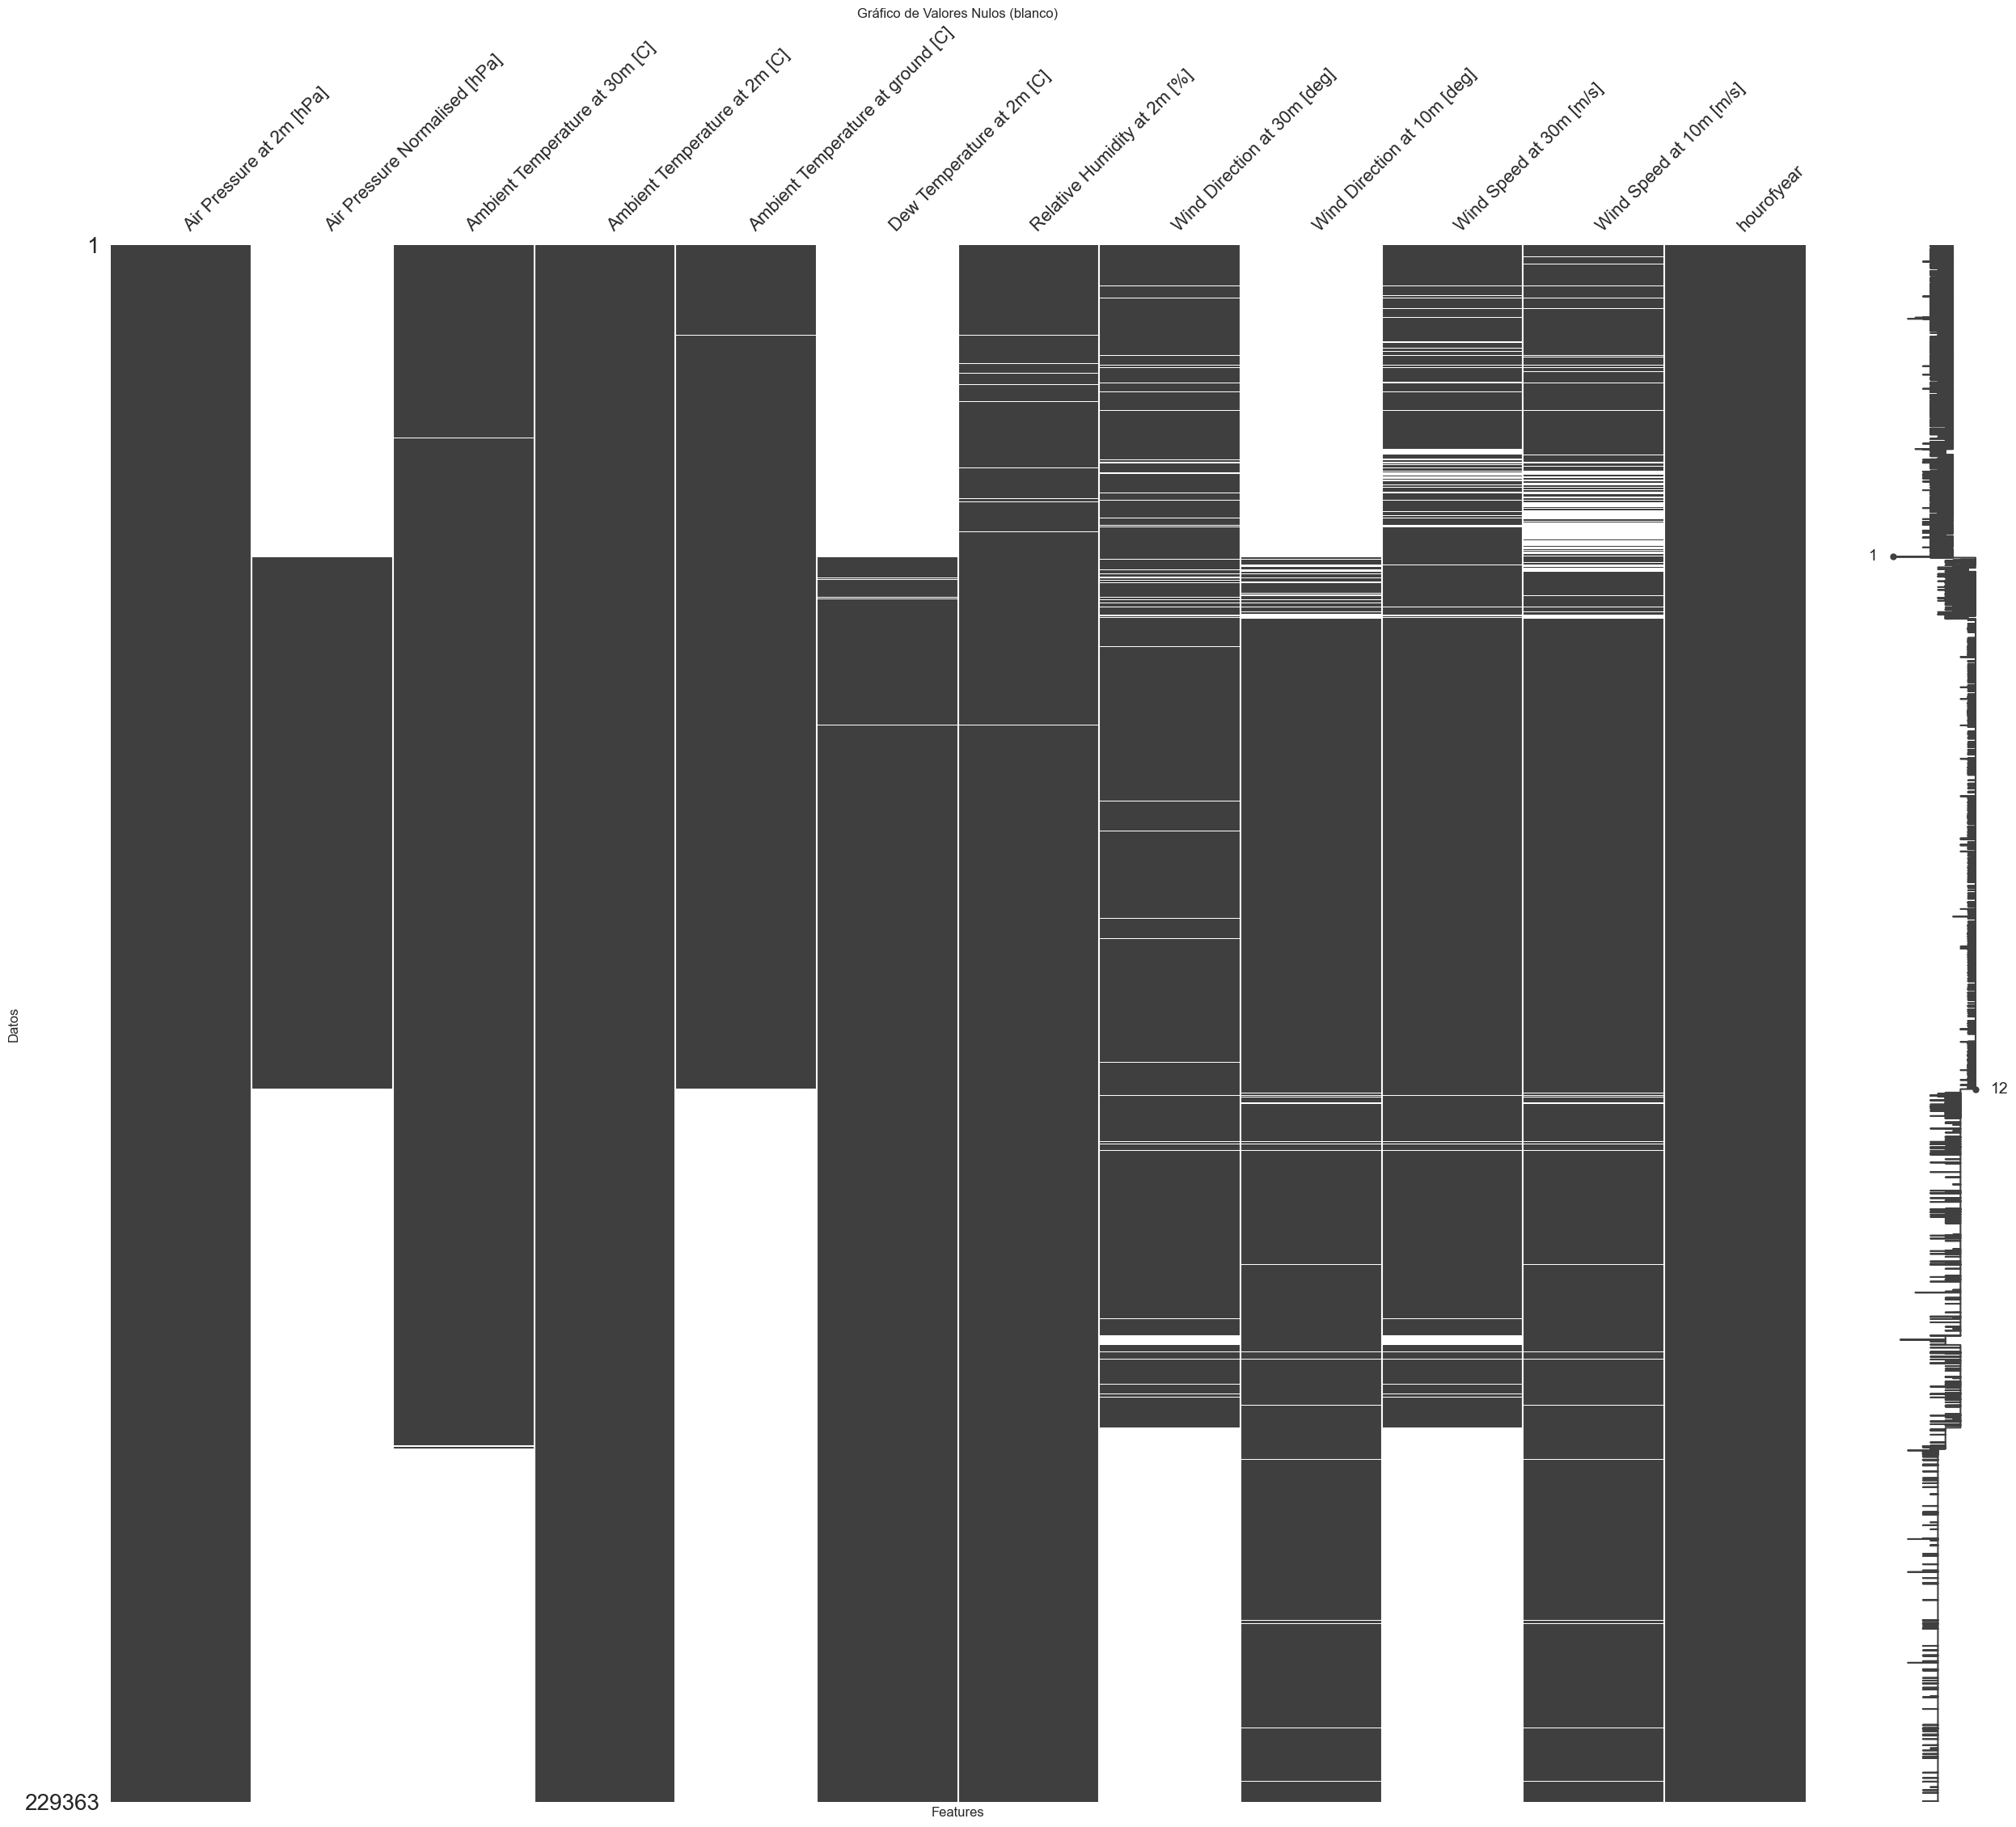

In [156]:
## general values of nan values
plt.clf()
msno.matrix(df)
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
plt.gcf().set_size_inches(30, 25)
plt.savefig("../plots/nullplot.png",dpi = 100)

In [146]:
df.isna().sum()

Air Pressure at 2m [hPa]                 13
Air Pressure Normalised [hPa]        151082
Ambient Temperature at 30m [C]        52550
Ambient Temperature at 2m [C]            79
Ambient Temperature at ground [C]    105363
Dew Temperature at 2m [C]             46551
Relative Humidity at 2m [%]            1001
Wind Direction at 30m [deg]           62095
Wind Direction at 10m [deg]           50252
Wind Speed at 30m [m/s]               63455
Wind Speed at 10m [m/s]               14478
dtype: int64

In [147]:
print('last record before nan values of temperature ar ground: ',df[df['Ambient Temperature at ground [C]'].notna()]['Ambient Temperature at ground [C]'].index[-1])

last record before nan values of temperature ar ground:  2008-08-16 20:00:00


## Correlations

In [148]:
## getting principal correlations in excel format, located in corraltions/
top_negative_correlations,top_positive_correlations,less_correlated = get_principal_correlations(df.corr(),n_display=20)

/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_15775/2319257006.py:134: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]


In [149]:
top_negative_correlations.to_excel('correlations/top_negative_correlations.xlsx',index=False)
top_positive_correlations.to_excel('correlations/top_positive_correlations.xlsx' ,index=False)
less_correlated.to_excel('correlations/less_correlated.xlsx',index=False)

# Plot Analysis

## Historic Histogram

* Folder: ../plots/historic_histograms/

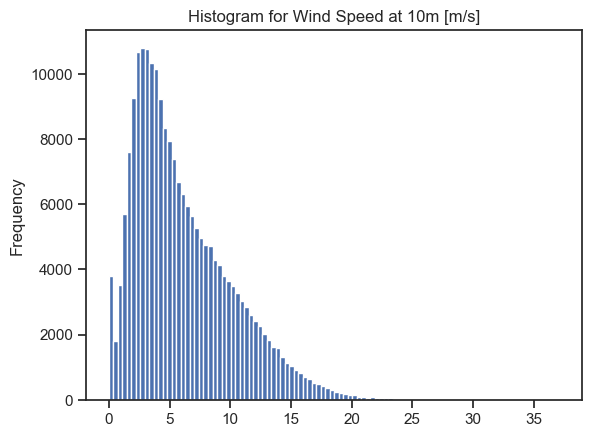

In [150]:
for variable in numeric_col:
    plot_historic_histogram(variable) # this function save the plot
    

## Histogram by year
* Folder: ../plots/histograms_per_year/

In [ ]:
for variable in numeric_col:
    plot_density_by_year(variable) # save the plot

## Scatterplot

<Figure size 640x480 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

<Figure size 600x600 with 0 Axes>

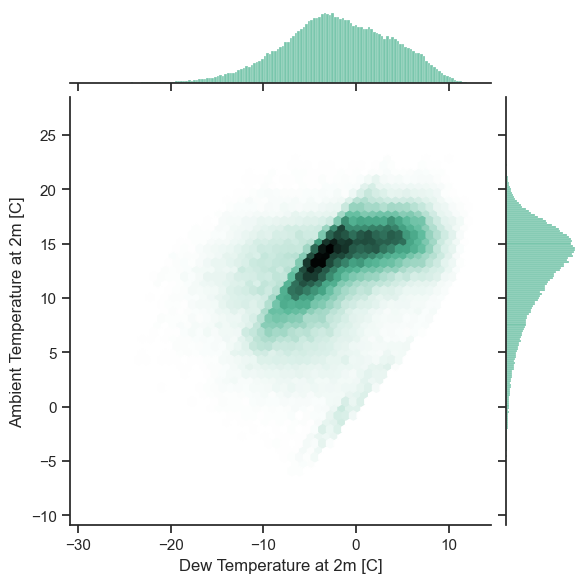

In [152]:
# Here I selected most interesting correlations I saw
# most correlated
pair1 = ('Relative Humidity at 2m [%]',	'Ambient Temperature at 2m [C]')


pairs = (
('Relative Humidity at 2m [%]',	'Ambient Temperature at 2m [C]'),
('Wind Speed at 30m [m/s]'	,'Ambient Temperature at 30m [C]'),
('Dew Temperature at 2m [C]',	'Ambient Temperature at ground [C]'),
('Relative Humidity at 2m [%]',	'Dew Temperature at 2m [C]'),
('Dew Temperature at 2m [C]',	'Ambient Temperature at 2m [C]')
         )
for pair in pairs:
    # plot_and_save_scatter(pair[0],pair[1])
    plot_and_save_hexbin(pair[0],pair[1])

Relative Humidity at 2m [%] and Ambient Temperature at 2m [C] which are the variables with more non-nan values, don't show a specific pattern historically, lets see for exmple in 2023 year

<Figure size 640x480 with 0 Axes>

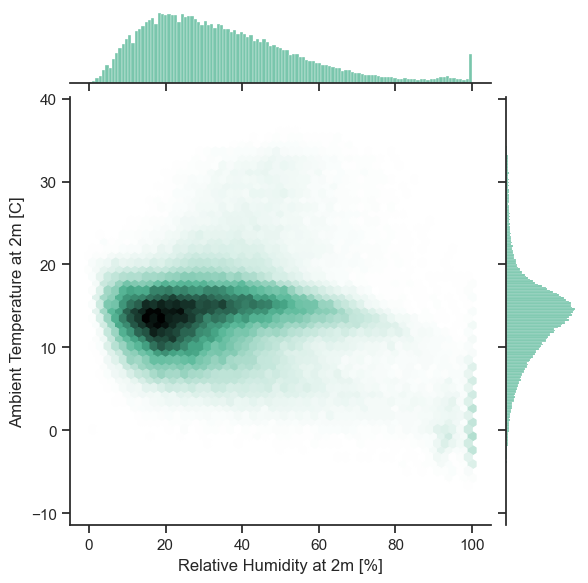

In [153]:
_df = df[df.index.year==2023]
variable1,variable2 = 'Relative Humidity at 2m [%]',	'Ambient Temperature at 2m [C]'
plt.clf()
sns.jointplot(x=df[variable1], y=df[variable2], kind="hex", color="#4CB391")
plt.xlabel(f'{variable1}')
plt.ylabel(f'{variable2}')
plt.show()

we got the same

## Historical Timeseries error

<Figure size 640x480 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

<Figure size 2000x700 with 0 Axes>

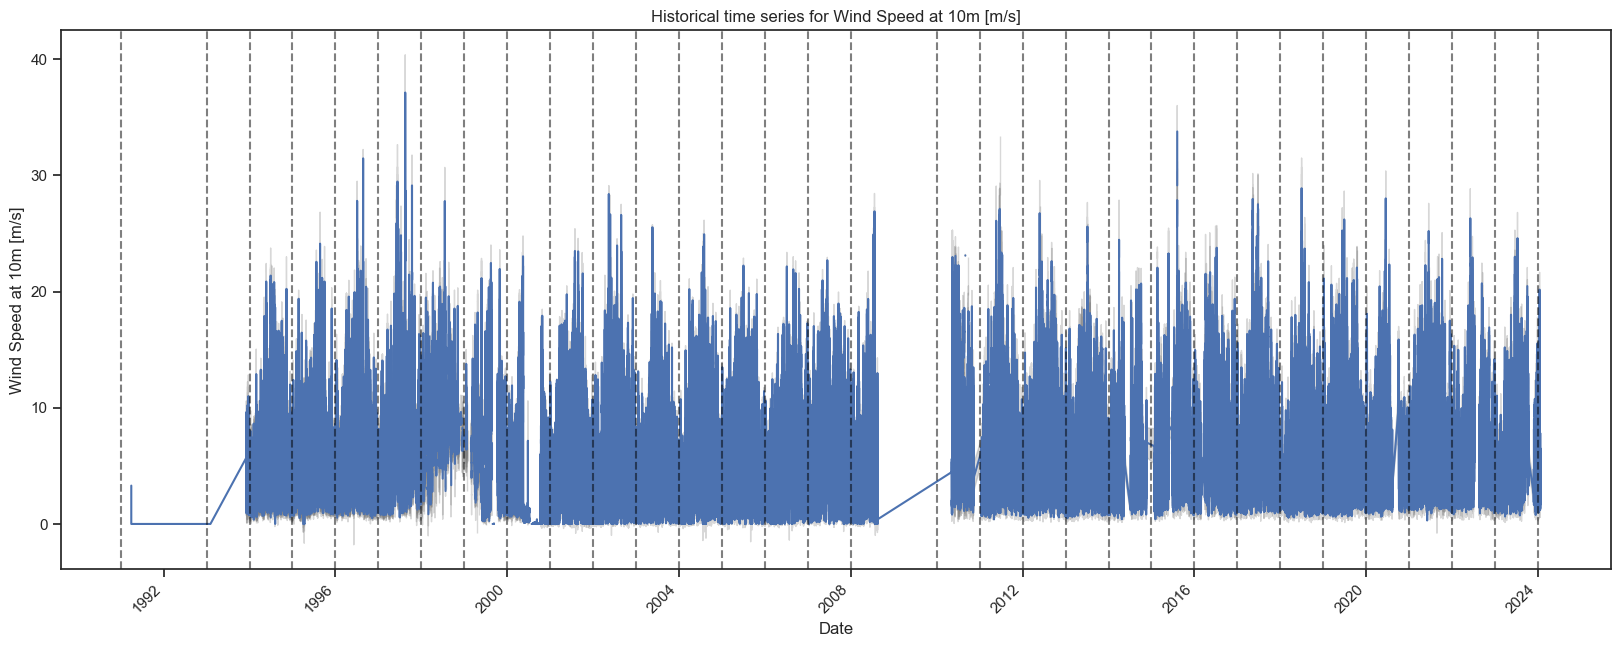

In [154]:
for variable in numeric_col:
    plot_timeseries_err(variable) # saving plots

## Time series subplots

In [ ]:
for variable in numeric_col:
    plot_timeseries_subplots(variable) # saving plots in plots/histograms_per_year

Remark:
* Ambient Temperature at ground [C] in lasts years available shows a pattern for winter season where tends to get lowers temperatures
* Rest variables needs more details